In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgenmulti
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [7]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna

CPU times: user 388 ms, sys: 2.25 s, total: 2.64 s
Wall time: 2.62 s


AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')
scatac

CPU times: user 1.4 s, sys: 23.6 s, total: 25 s
Wall time: 24.9 s


AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

# Train the model

In [9]:
network = scgenmulti.CVAEArithKeras([scrna.shape[1], scatac.shape[1]], 4,
                                     z_dimension=10, h_dimension=800, 
                                     learning_rate=0.0001, alpha=1, beta=1)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 3000)         0                                            
__________________________________________________________________________________________________
condition_0 (InputLayer)        (None, 4)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 20002)        0                                            
__________________________________________________________________________________________________
condition_1 (InputLayer)        (None, 4)            0                                            
________________________________________________________________________________________________

In [10]:
batch_size = 30000
n_iter = 20
i, j, n = 0, 0, 0
history = []
for n in range(n_iter):
    print('-' * 50)
    print('Iteration: {}'.format(n))
    if i + batch_size < scrna.shape[0]:
        scrna_batch = scrna[i:i+batch_size]
    else:
        select = list(range(i, scrna.shape[0]))
        select += list(range(i + batch_size - scrna.shape[0]))
        scrna_batch = scrna[select]
    if j + batch_size < scatac.shape[0]:
        scatac_batch = scatac[j:j+batch_size]
    else:
        select = list(range(j, scatac.shape[0]))
        select += list(range(j + batch_size - scatac.shape[0]))
        scatac_batch = scatac[select]
        
    i = (i + batch_size) % scrna.shape[0]
    j = (j + batch_size) % scatac.shape[0]
    
    %time history.append(network.train([scrna_batch, scatac_batch], n_epochs=1, batch_size=128, verbose=1))
    
    del scrna_batch
    del scatac_batch
    gc.collect()

--------------------------------------------------
Iteration: 0

Epoch 1/1
30000/30000 [==============================] - 17s 567us/step - loss: 1059.3644 - VAE_0_loss: 240.1495 - VAE_1_loss: 819.1429 - VAE_0_kl_loss: 17.4041 - VAE_0_recon_loss: 222.7188 - VAE_0_kl_loss_latents: 0.1638 - VAE_1_kl_loss: 17.4041 - VAE_1_recon_loss: 801.5110 - VAE_1_kl_loss_latents: 0.1638
CPU times: user 35.2 s, sys: 15.5 s, total: 50.7 s
Wall time: 48 s
--------------------------------------------------
Iteration: 1
Epoch 1/1
30000/30000 [==============================] - 23s 758us/step - loss: 915.9927 - VAE_0_loss: 205.0576 - VAE_1_loss: 710.9135 - VAE_0_kl_loss: 17.7705 - VAE_0_recon_loss: 187.1943 - VAE_0_kl_loss_latents: 0.0961 - VAE_1_kl_loss: 17.7705 - VAE_1_recon_loss: 693.0654 - VAE_1_kl_loss_latents: 0.096113s - loss: 937.5825 - VAE_0_loss: 216.0351 - VAE_1_loss: 721.5476 - VAE_0_kl_loss: 18.7284 - VAE_0_recon_loss: - ETA: 5s - loss: 922.2643 - VAE_0_loss: 207.8697 - VAE_1_loss: 714.3947 - VAE

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


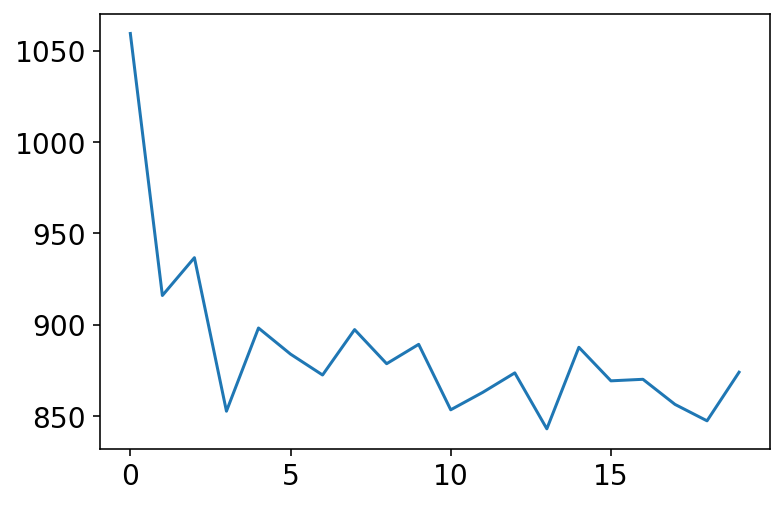

In [11]:
plt.plot([i.history['loss'] for i in history]);

# Visualization

In [12]:
scrna_latent = network.to_latent(scrna, modality=0)[0]
scrna_latent = sc.AnnData(scrna_latent)
scrna_latent.obs = scrna.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

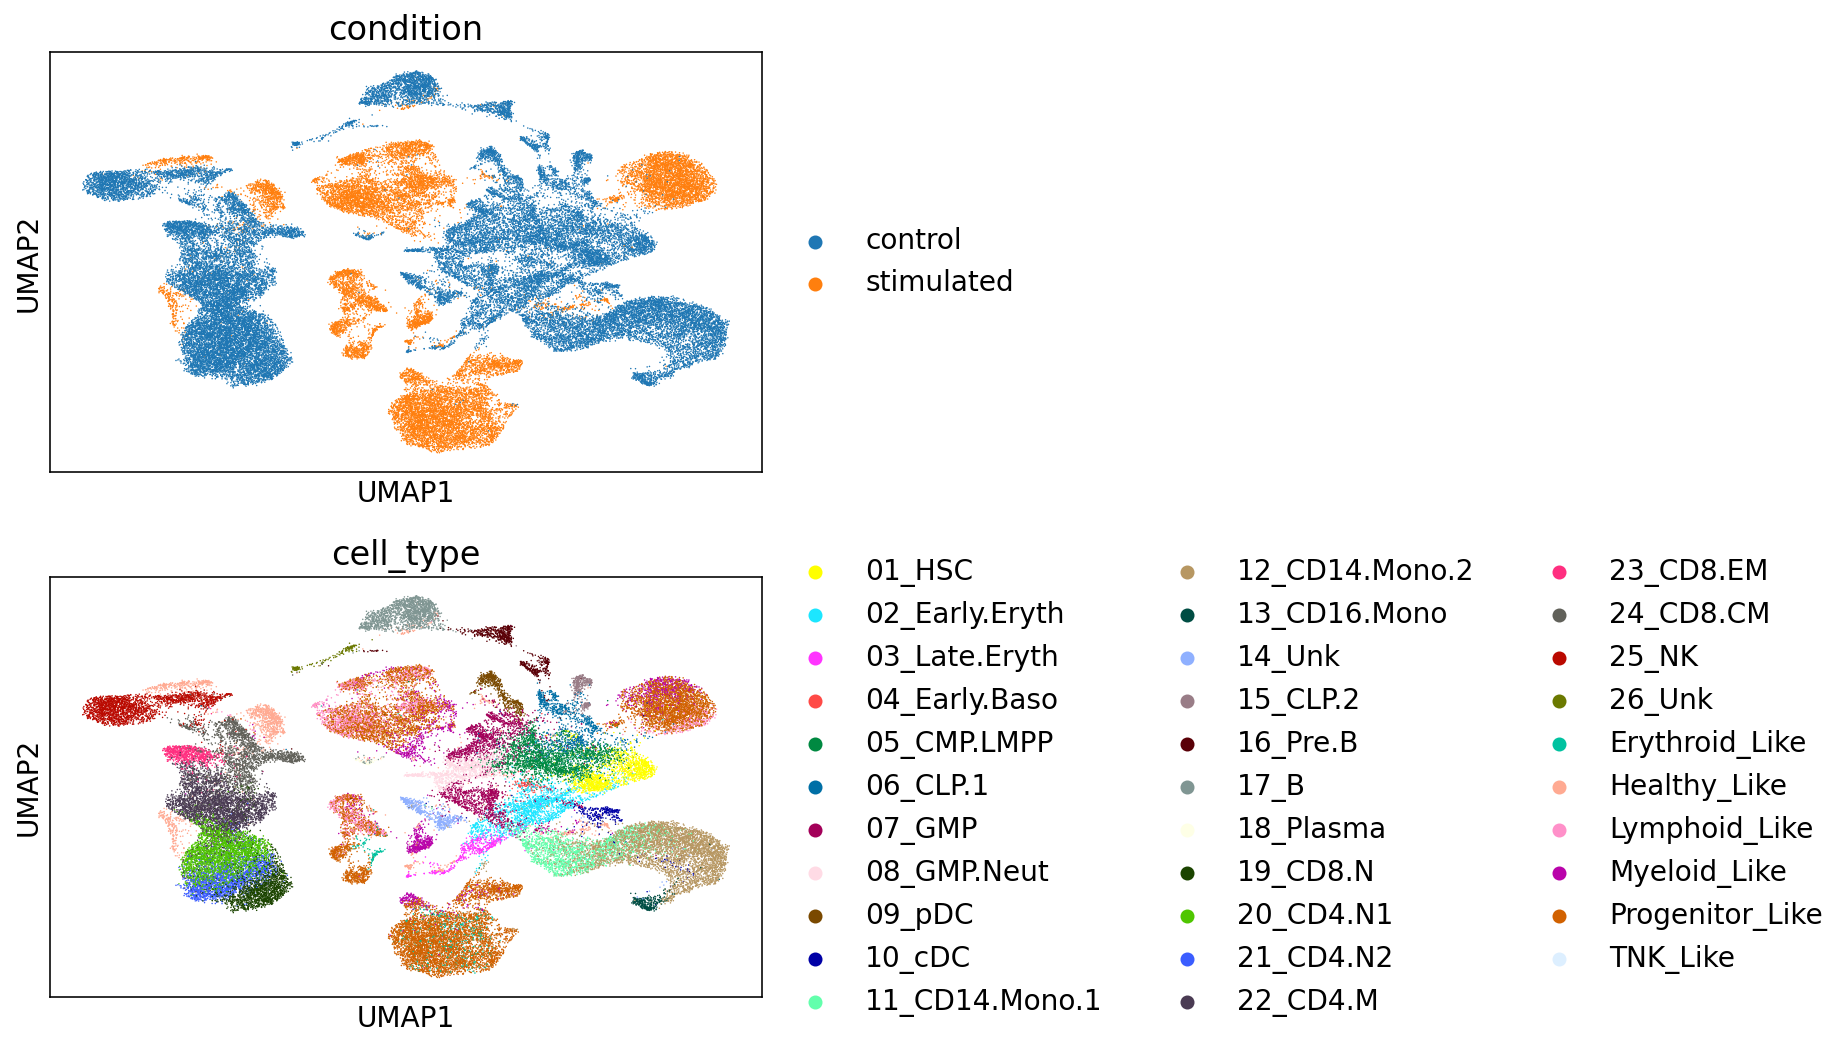

In [13]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

In [14]:
scatac_latent = network.to_latent(scatac, 1)[0]
scatac_latent = sc.AnnData(scatac_latent)
scatac_latent.obs = scatac.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


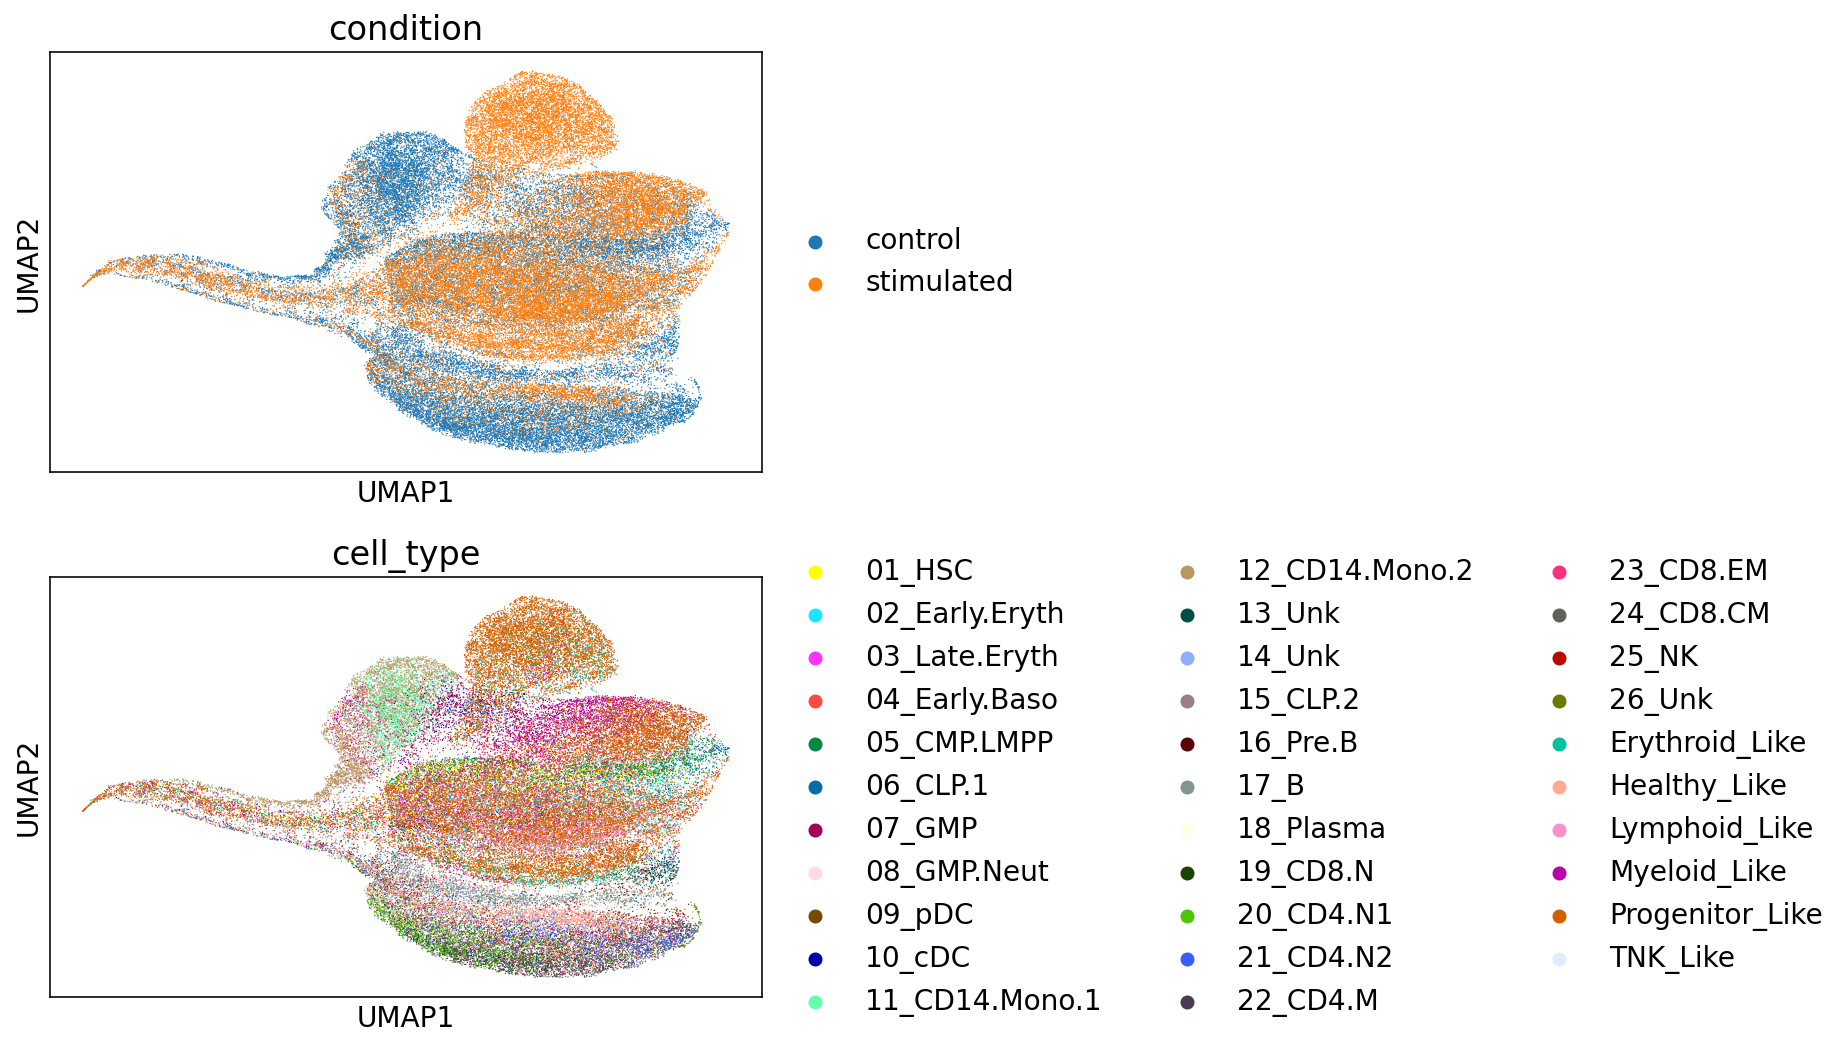

CPU times: user 5min 38s, sys: 6.01 s, total: 5min 44s
Wall time: 1min 50s


In [15]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

In [16]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs
scatacobs = scatac.obs
scrnaobs['modality'] = 'scRNA'
scatacobs['modality'] = 'scATAC'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


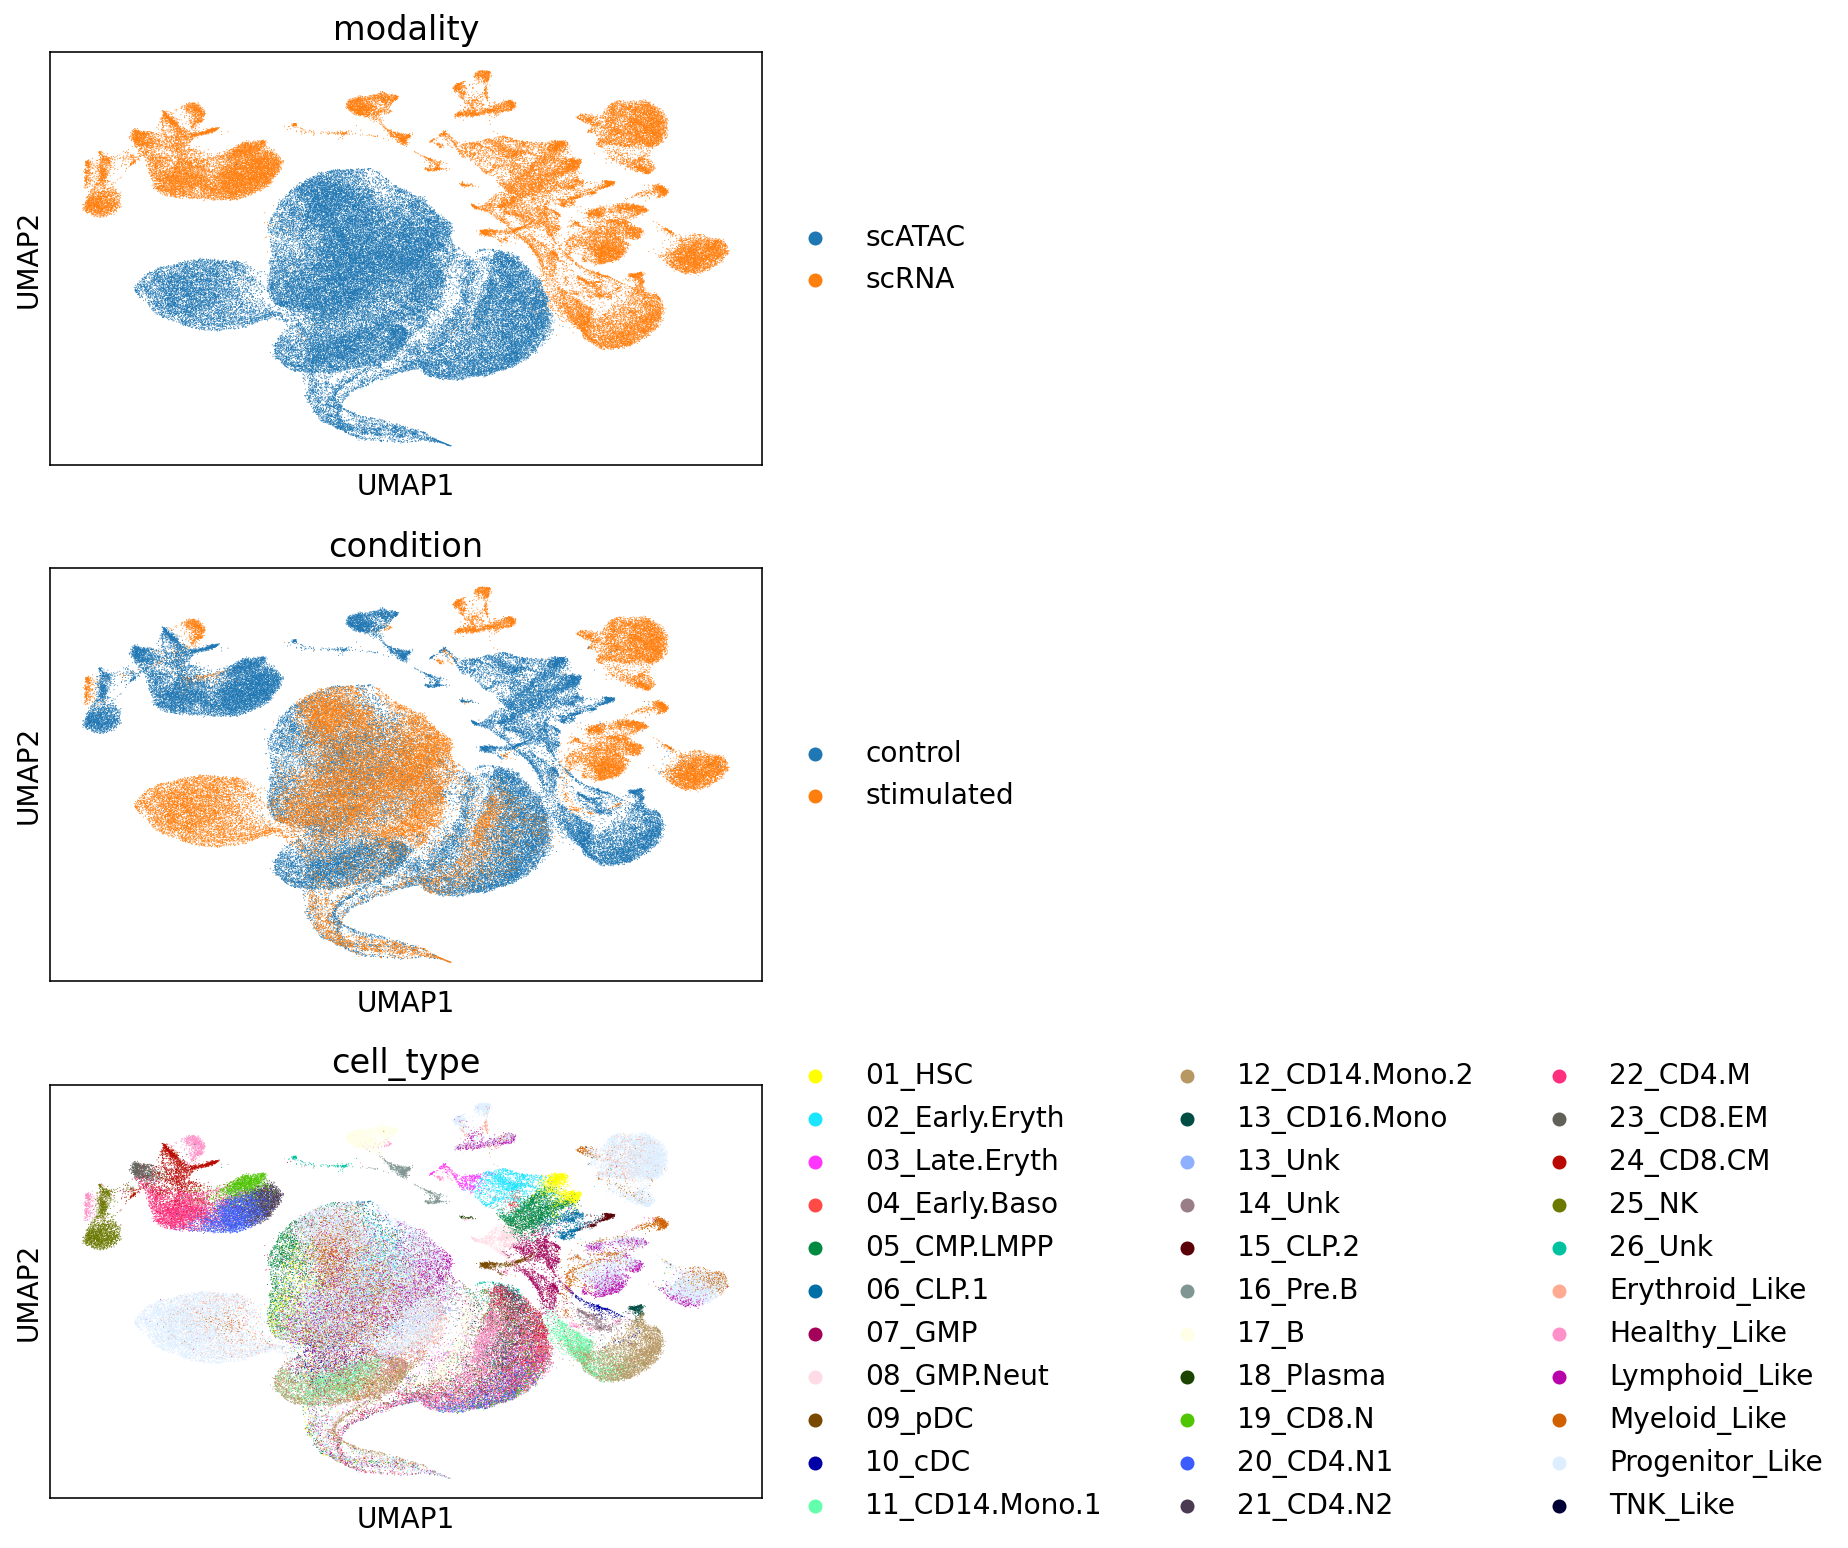

CPU times: user 14min 48s, sys: 19.8 s, total: 15min 8s
Wall time: 3min 41s


In [17]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)